In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

import src
from src.reload import deep_reload

In [2]:
gdf_zones = gpd.read_file('../charger_network_analysis/Data/NGOD/Shapes/V2_Zones.shp')

gdf_zones['in_california'] = gdf_zones['V2ZONEID'].apply(lambda zid: 'CA' in zid)

gdf_zones_california = gdf_zones[gdf_zones['in_california']]

gdf_zones_california = gdf_zones_california.explode(drop = True)

In [3]:
expected_test_duration = 300

In [4]:
# Loading Info

graph = src.graph.graph_from_json('graph.json')

In [5]:
deep_reload(src)

parameters_sr = json.load(open('CEC/parameters_cec_router_short_routes.json', 'rb'))

cases_sr = src.router.produce_routing_inputs(
    graph, parameters_sr, tt = expected_test_duration
)

In [6]:
deep_reload(src)

cases = cases_sr

final_routes_sr = []

for key in src.progress_bar.ProgressBar(list(cases.keys()), end_color = ''):

    # try:

    case = cases[key]

    raw_routes, raw_route_weights, success = src.router.router(case)

    routes = src.router.route_information(graph, raw_routes, parameters_sr['route_fields'])

    full_routes = []
    
    for idx, route in enumerate(routes):

        if len(route['nodes']) > 3:
    
            route['vehicle'] = case['information']['vehicle']
            route['depot'] = case['information']['depot']
            route['km'] = raw_route_weights[idx][0] / 1000
            route['hours'] = raw_route_weights[idx][1] / 3600
    
            full_routes.append(route)

    final_routes_sr.extend(full_routes)

    # except:
    
    #     pass

 [------------->] (12/12) 100.00%, 1.39 it/s, 9.38 s elapsed, 0.00 s remaining

In [7]:
n_routes = len(final_routes_sr)
stations = np.array([len(r['nodes']) for r in final_routes_sr])
chargers = np.array([sum(r['chargers']) for r in final_routes_sr])
hours = np.array([r['hours'] for r in final_routes_sr])
nodes_visited = np.unique(np.concatenate([r['nodes'] for r in final_routes_sr]))
            
n_routes, sum(stations), sum(chargers), sum(hours)

(212, 894, 1149.0, 701.5617747152544)

In [8]:
print(
    sum(stations)/n_routes, sum(chargers)/n_routes,
    sum(hours)/sum(stations), sum(hours)/sum(chargers)
 )

4.216981132075472 5.419811320754717 0.7847447144465933 0.6105846603265922


[0.14948452 0.32530794 0.50113135 0.67695476 0.85277817 1.02860159
 1.204425   1.38024841 1.55607182 1.73189524 1.90771865] [16 41 42 42 48  2 18  1  0  2]


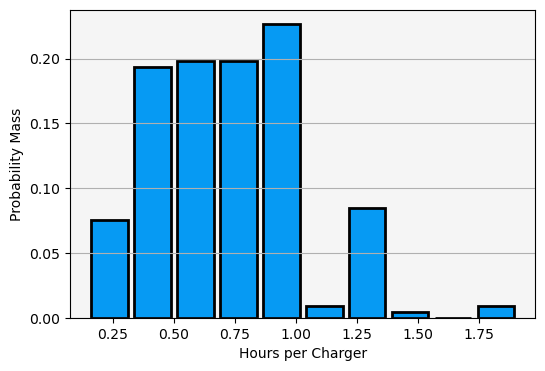

In [9]:
fig, ax = plt.subplots(figsize = (6, 4))

kw = {
    # 'fc': 'lightgray',
    'fc': 'xkcd:azure',
    'ec': 'k',
    'width': .15,
    'lw': 2,
}

efficiency = hours/chargers

hist, bins = np.histogram(efficiency)

print(bins, hist)

ax.bar((bins[:-1] + bins[1:]) / 2, hist / sum(hist), **kw)

ax.set(**{
    'xlabel': 'Hours per Charger',
    'ylabel': 'Probability Mass',
    'facecolor': 'whitesmoke',
})

ax.grid(axis = 'y')

(array([0.    , 0.3333, 0.6666, 0.9999,    nan]), array([ 249,  106,  105,   12, 1531]))
(array([0.    , 0.9999]), array([2000,    3]))


[None]

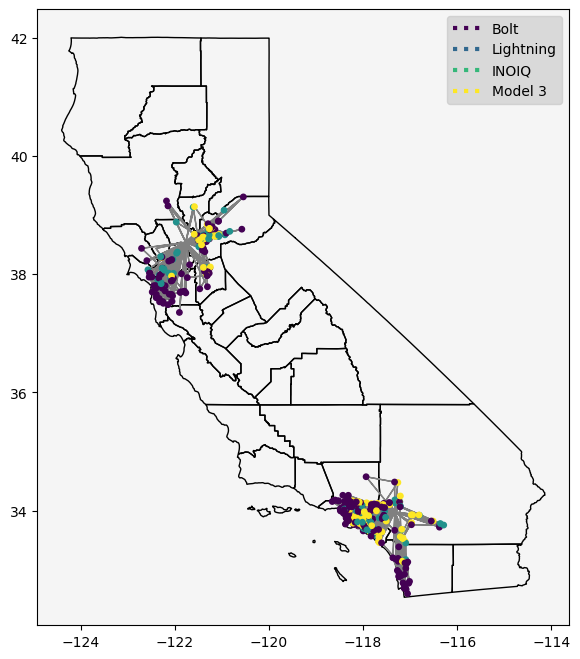

In [10]:
deep_reload(src)

routes = final_routes_sr

node_to_idx, idx_to_node = src.router.assignments(list(graph.nodes))

raw_routes = [[node_to_idx[n] for n in r['nodes']] for r in routes]

for node, info in graph._node.items():
    info['route_depot'] = 0
    if node >= 1000000000:
        info['is_depot'] = True
    else:
        info['is_depot'] = False

for route in routes:
    # print(route['vehicle'])
    if 'Bolt' in route['vehicle']:
        vn = 0

    elif 'Lightning' in route['vehicle']:
        vn = 1/3

    elif 'IONIQ' in route['vehicle']:
        vn = 2/3

    elif 'Model' in route['vehicle']:
        vn = 3/3
    else:
        vn = 0
    # print(vn)
    for n in route['nodes']:
        graph._node[n]['route_depot'] = vn

for node, info in graph._node.items():

    if node not in nodes_visited:

        graph._node[node]['route_depot'] = np.nan

arrow_kwargs = {
    'color': 'gray',
    'zorder': 0,
}

depot_kwargs = {
    'marker': 'h',
    's': 200,
    # 'c': 'k',
}

destination_kwargs = {
    's': 15,
}

fig, ax = plt.subplots(figsize = (8, 8))

gdf_zones_california.plot(ax = ax, fc = 'none', ec = 'k', zorder = 0)

src.figures.PlotRoutes(graph, raw_routes, ax = ax,
                       arrow_kwargs = arrow_kwargs,
                       depot_kwargs = depot_kwargs,
                       destination_kwargs = destination_kwargs,
                      )
from matplotlib.lines import Line2D

colors = src.figures.ReturnColorMap('viridis')(np.array([0, 1/3, 2/3, 1]))
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='dotted') for c in colors]
labels = ['Bolt', 'Lightning', 'INOIQ', 'Model 3']
ax.legend(lines, labels, facecolor = 'lightgray', markerscale = 40)

ax.set(**{'facecolor': 'whitesmoke'})
# src.figures.PlotGraph(src.graph.subgraph(graph, [1000000000, 2000000000, 3000000000]), ax = ax)

In [11]:
all_nodes = np.array(list(graph.nodes))
nodes_not_visited = np.setdiff1d(all_nodes, nodes_visited[nodes_visited < 1000000000])

graph_rr = src.graph.subgraph(graph, nodes_not_visited)

In [12]:
deep_reload(src)

parameters_rr = json.load(open('CEC/parameters_cec_router_regular_routes.json', 'rb'))

cases_rr = src.router.produce_routing_inputs(
    graph_rr, parameters_rr, tt = expected_test_duration
)

In [13]:
deep_reload(src)

cases = cases_rr

final_routes_rr = []

for key in src.progress_bar.ProgressBar(list(cases.keys()), end_color = ''):

    # try:

    case = cases[key]

    raw_routes, raw_route_weights, success = src.router.router(case)

    routes = src.router.route_information(graph, raw_routes, parameters_rr['route_fields'])

    full_routes = []
    
    for idx, route in enumerate(routes):

        if len(route['nodes']) > 3:
    
            route['vehicle'] = case['information']['vehicle']
            route['depot'] = case['information']['depot']
            route['km'] = raw_route_weights[idx][0] / 1000
            route['hours'] = raw_route_weights[idx][1] / 3600
    
            full_routes.append(route)

    final_routes_rr.extend(full_routes)

    # except:
    
    #     pass

 [------------->] (12/12) 100.00%, 6.88 it/s, 1.89 s elapsed, 0.00 s remaining

In [14]:
n_routes = len(final_routes_rr)
stations = np.array([len(r['nodes']) for r in final_routes_rr])
chargers = np.array([sum(r['chargers']) for r in final_routes_rr])
hours = np.array([r['hours'] for r in final_routes_rr])
nodes_visited = np.unique(np.concatenate([r['nodes'] for r in final_routes_rr]))
            
n_routes, sum(stations), sum(chargers), sum(hours)

(191, 1038, 2632.0, 1246.0363175430662)

In [15]:
print(
    sum(stations)/n_routes, sum(chargers)/n_routes,
    sum(hours)/sum(stations), sum(hours)/sum(chargers)
 )

5.43455497382199 13.780104712041885 1.200420344453821 0.4734180537777607


[0.13282985 0.47875682 0.82468379 1.17061076 1.51653773 1.8624647
 2.20839167 2.55431864 2.90024561 3.24617258 3.59209955] [65 51 30 22  9  7  2  2  2  1]


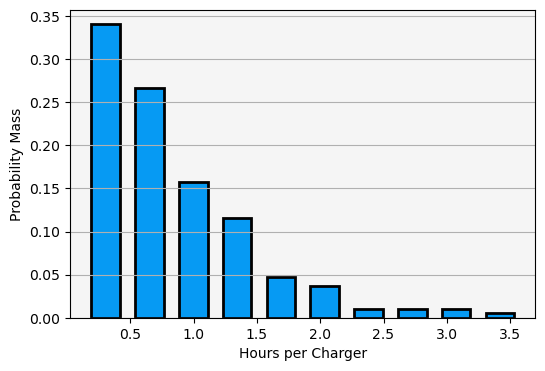

In [16]:
fig, ax = plt.subplots(figsize = (6, 4))

kw = {
    # 'fc': 'lightgray',
    'fc': 'xkcd:azure',
    'ec': 'k',
    'width': .225,
    'lw': 2,
}

efficiency = hours/chargers

hist, bins = np.histogram(efficiency)

print(bins, hist)

ax.bar((bins[:-1] + bins[1:]) / 2, hist / sum(hist), **kw)

ax.set(**{
    'xlabel': 'Hours per Charger',
    'ylabel': 'Probability Mass',
    'facecolor': 'whitesmoke',
})

ax.grid(axis = 'y')

(array([0.    , 0.3333, 0.6666, 0.9999,    nan]), array([ 214,  183,  142,  120, 1344]))
(array([0.    , 0.9999]), array([2000,    3]))


[None]

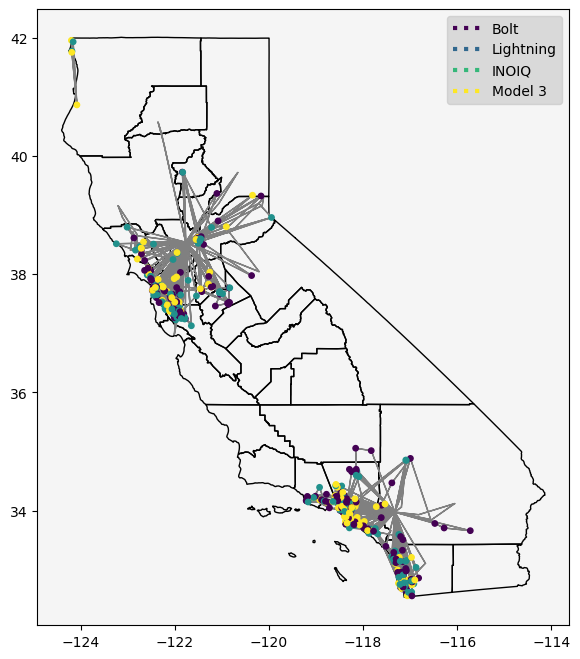

In [17]:
deep_reload(src)

routes = final_routes_rr

node_to_idx, idx_to_node = src.router.assignments(list(graph.nodes))

raw_routes = [[node_to_idx[n] for n in r['nodes']] for r in routes]

for node, info in graph._node.items():
    info['route_depot'] = 0
    if node >= 1000000000:
        info['is_depot'] = True
    else:
        info['is_depot'] = False

for route in routes:
    # print(route['vehicle'])
    if 'Bolt' in route['vehicle']:
        vn = 0

    elif 'Lightning' in route['vehicle']:
        vn = 1/3

    elif 'IONIQ' in route['vehicle']:
        vn = 2/3

    elif 'Model' in route['vehicle']:
        vn = 3/3
    else:
        vn = 0
    # print(vn)
    for n in route['nodes']:
        graph._node[n]['route_depot'] = vn

for node, info in graph._node.items():

    if node not in nodes_visited:

        graph._node[node]['route_depot'] = np.nan

arrow_kwargs = {
    'color': 'gray',
    'zorder': 0,
}

depot_kwargs = {
    'marker': 'h',
    's': 200,
    # 'c': 'k',
}

destination_kwargs = {
    's': 15,
}

fig, ax = plt.subplots(figsize = (8, 8))

gdf_zones_california.plot(ax = ax, fc = 'none', ec = 'k', zorder = 0)

src.figures.PlotRoutes(graph, raw_routes, ax = ax,
                       arrow_kwargs = arrow_kwargs,
                       depot_kwargs = depot_kwargs,
                       destination_kwargs = destination_kwargs,
                      )
from matplotlib.lines import Line2D

colors = src.figures.ReturnColorMap('viridis')(np.array([0, 1/3, 2/3, 1]))
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='dotted') for c in colors]
labels = ['Bolt', 'Lightning', 'INOIQ', 'Model 3']
ax.legend(lines, labels, facecolor = 'lightgray', markerscale = 40)

ax.set(**{'facecolor': 'whitesmoke'})
# src.figures.PlotGraph(src.graph.subgraph(graph, [1000000000, 2000000000, 3000000000]), ax = ax)

In [18]:
all_nodes = np.array(list(graph_rr.nodes))
nodes_not_visited = np.setdiff1d(all_nodes, nodes_visited[nodes_visited < 1000000000])

graph_lr = src.graph.subgraph(graph_rr, nodes_not_visited)

In [19]:
deep_reload(src)

parameters_lr = json.load(open('CEC/parameters_cec_router_long_routes.json', 'rb'))

cases_lr = src.router.produce_routing_inputs(
    graph_lr, parameters_lr, tt = expected_test_duration
)

In [20]:
deep_reload(src)

cases = cases_lr

final_routes_lr = []

for key in src.progress_bar.ProgressBar(list(cases.keys()), end_color = ''):

    # try:

    case = cases[key]

    raw_routes, raw_route_weights, success = src.router.router(case)

    routes = src.router.route_information(graph, raw_routes, parameters_lr['route_fields'])

    full_routes = []
    
    for idx, route in enumerate(routes):

        if len(route['nodes']) > 3:
    
            route['vehicle'] = case['information']['vehicle']
            route['depot'] = case['information']['depot']
            route['km'] = raw_route_weights[idx][0] / 1000
            route['hours'] = raw_route_weights[idx][1] / 3600
    
            full_routes.append(route)

    final_routes_lr.extend(full_routes)

    # except:
    
    #     pass

 [----------->] (12/12) 100.00%, 107.93 it/s, 0.12 s elapsed, 0.00 s remaining

In [21]:
n_routes = len(final_routes_lr)
stations = np.array([len(r['nodes']) for r in final_routes_lr])
chargers = np.array([sum(r['chargers']) for r in final_routes_lr])
hours = np.array([r['hours'] for r in final_routes_lr])
nodes_visited = np.unique(np.concatenate([r['nodes'] for r in final_routes_lr]))
            
n_routes, sum(stations), sum(chargers), sum(hours)

(34, 299, 699.0, 531.7145333065024)

In [22]:
print(
    sum(stations)/n_routes, sum(chargers)/n_routes,
    sum(hours)/sum(stations), sum(hours)/sum(chargers)
 )

8.794117647058824 20.558823529411764 1.7783094759414797 0.7606788745443525


[0.24866885 0.56976844 0.89086804 1.21196763 1.53306722 1.85416681
 2.1752664  2.49636599 2.81746558 3.13856517 3.45966476] [ 4 15  7  1  1  3  0  0  0  3]


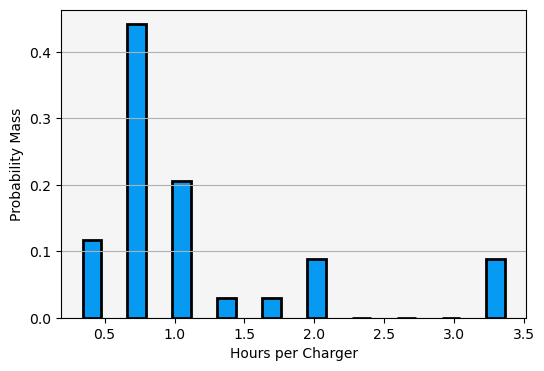

In [23]:
fig, ax = plt.subplots(figsize = (6, 4))

kw = {
    # 'fc': 'lightgray',
    'fc': 'xkcd:azure',
    'ec': 'k',
    'width': .135,
    'lw': 2,
}

efficiency = hours/chargers

hist, bins = np.histogram(efficiency)

print(bins, hist)

ax.bar((bins[:-1] + bins[1:]) / 2, hist / sum(hist), **kw)

ax.set(**{
    'xlabel': 'Hours per Charger',
    'ylabel': 'Probability Mass',
    'facecolor': 'whitesmoke',
})

ax.grid(axis = 'y')

(array([0.    , 0.3333, 0.6666,    nan]), array([  42,   32,   21, 1908]))
(array([0.    , 0.9999]), array([2000,    3]))


[None]

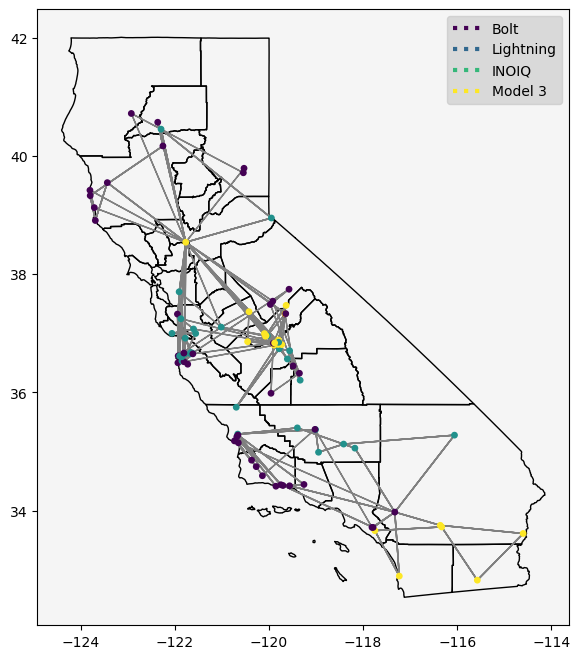

In [24]:
deep_reload(src)

routes = np.random.choice(final_routes_lr, len(final_routes_lr), replace = False)

node_to_idx, idx_to_node = src.router.assignments(list(graph.nodes))

raw_routes = [[node_to_idx[n] for n in r['nodes']] for r in routes]

for node, info in graph._node.items():
    info['route_depot'] = 0
    if node >= 1000000000:
        info['is_depot'] = True
    else:
        info['is_depot'] = False

for route in routes:
    # print(route['vehicle'])
    if 'Bolt' in route['vehicle']:
        vn = 0

    elif 'Lightning' in route['vehicle']:
        vn = 1/3

    elif 'IONIQ' in route['vehicle']:
        vn = 2/3

    elif 'Model' in route['vehicle']:
        vn = 0
    else:
        vn = 0
    # print(vn)
    for n in route['nodes']:
        graph._node[n]['route_depot'] = vn

for node, info in graph._node.items():

    if node not in nodes_visited:

        graph._node[node]['route_depot'] = np.nan

arrow_kwargs = {
    'color': 'gray',
    'zorder': 0,
}

depot_kwargs = {
    'marker': 'h',
    's': 200,
    # 'c': 'k',
}

destination_kwargs = {
    's': 15,
}

fig, ax = plt.subplots(figsize = (8, 8))

gdf_zones_california.plot(ax = ax, fc = 'none', ec = 'k', zorder = 0)

src.figures.PlotRoutes(graph, raw_routes, ax = ax,
                       arrow_kwargs = arrow_kwargs,
                       depot_kwargs = depot_kwargs,
                       destination_kwargs = destination_kwargs,
                      )
from matplotlib.lines import Line2D

colors = src.figures.ReturnColorMap('viridis')(np.array([0, 1/3, 2/3, 1]))
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='dotted') for c in colors]
labels = ['Bolt', 'Lightning', 'INOIQ', 'Model 3']
ax.legend(lines, labels, facecolor = 'lightgray', markerscale = 40)

ax.set(**{'facecolor': 'whitesmoke'})
# src.figures.PlotGraph(src.graph.subgraph(graph, [1000000000, 2000000000, 3000000000]), ax = ax)